# week 09 PyTorch practice, hints and Dataloaders

Credits:
* First part is based on YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
* Second part is based on PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
* Third part is based on PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

__This notebook__ will teach you to use pytorch low-level core. You can install it [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like tensorflow/theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

Let's dive into it!

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms

### Task 1: Tensormancy

__1.1 The [_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)__

Let's write function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (6 \cdot \theta) ) \cdot (1 + 0.01 \cdot cos(24 \cdot \theta)) \cdot (0.5 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (10 + sin(10 \cdot \theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

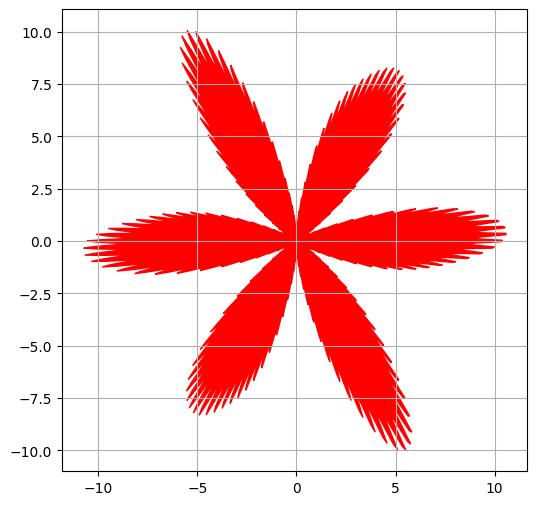

In [25]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.cos(6 * theta)) * (1 + 0.01 * torch.cos(24 * theta)) * (0.5 + 0.05 * torch.cos(200 * theta)) * (10 + torch.sin(10 * theta))  # YOUR CODE HERE

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * torch.cos(theta)  # YOUR CODE HERE
y = rho * torch.sin(theta)  # YOUR CODE HERE


plt.figure(figsize=(6, 6))
plt.fill(x.numpy(), y.numpy(), color="red")
plt.grid()

### Task 2: Using the Dataloader

In [26]:
from torch import nn
from torch.nn import functional as F

In [27]:
!wget https://raw.githubusercontent.com/neychev/harbour_ml2020/master/day10_Optimization_and_regularization_in_DL/notmnist.py

--2025-02-16 09:25:16--  https://raw.githubusercontent.com/neychev/harbour_ml2020/master/day10_Optimization_and_regularization_in_DL/notmnist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1799 (1.8K) [text/plain]
Saving to: ‘notmnist.py.1’

notmnist.py.1       100%[===================>]   1.76K  --.-KB/s    in 0s      

2025-02-16 09:25:16 (30.1 MB/s) - ‘notmnist.py.1’ saved [1799/1799]



In [28]:
from notmnist import load_notmnist


X_train, y_train, X_test, y_test = load_notmnist()

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [29]:
print(Dataset.__doc__)

An abstract class representing a :class:`Dataset`.

    All datasets that represent a map from keys to data samples should subclass
    it. All subclasses should overwrite :meth:`__getitem__`, supporting fetching a
    data sample for a given key. Subclasses could also optionally overwrite
    :meth:`__len__`, which is expected to return the size of the dataset by many
    :class:`~torch.utils.data.Sampler` implementations and the default options
    of :class:`~torch.utils.data.DataLoader`. Subclasses could also
    optionally implement :meth:`__getitems__`, for speedup batched samples
    loading. This method accepts list of indices of samples of batch and returns
    list of samples.

    .. note::
      :class:`~torch.utils.data.DataLoader` by default constructs an index
      sampler that yields integral indices.  To make it work with a map-style
      dataset with non-integral indices/keys, a custom sampler must be provided.
    


In [30]:
class DatasetMNIST(Dataset):
    def __init__(self, path="./notMNIST_small", letters="ABCDEFGHIJ", transform=None):
        self.data, self.labels, _, _ = load_notmnist(path=path, letters=letters, test_size=0.1)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data[index].transpose(1, 2, 0)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [31]:
full_dataset = DatasetMNIST("./notMNIST_small", "AB", transform=None)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [32]:
# we can access and get data with index by __getitem__(index)
img, lab = full_dataset.__getitem__(0)

print(img.shape, type(img))
print(lab)

(28, 28, 1) <class 'numpy.ndarray'>
1


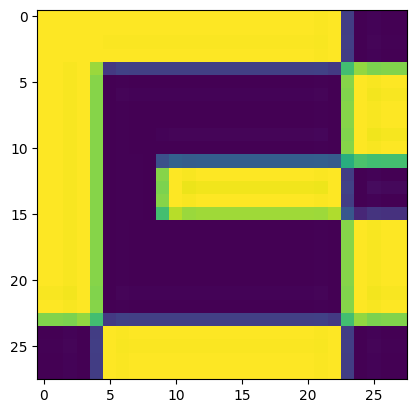

In [33]:
plt.imshow(img)

In [34]:
img_br, label_br = full_dataset[0]

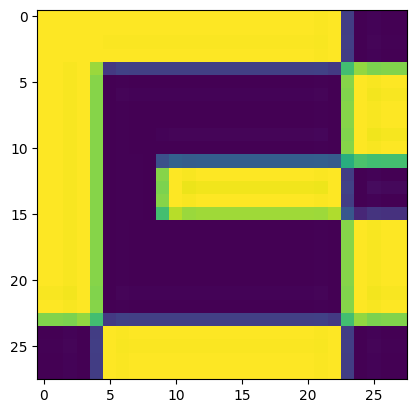

In [35]:
plt.imshow(img_br)

In [36]:
np.allclose(img, img_br)

True

In [37]:
img.shape

(28, 28, 1)

In [38]:
a = torchvision.transforms.ToTensor()

img_tensor = a(img)
img_tensor.shape

torch.Size([1, 28, 28])

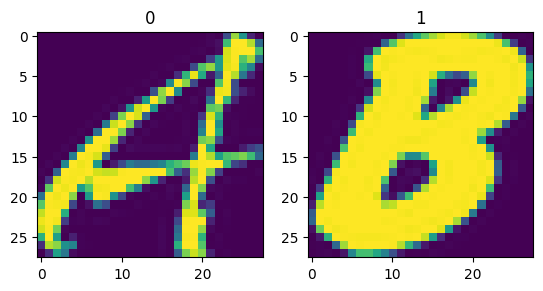

In [39]:
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28, 28]))
    plt.title(str(full_dataset[inds[i]][1]))

#### To the DataLoader

In [40]:
train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True, num_workers=2)

In [41]:
len(train_loader)

422

In [42]:
len(full_dataset)

3370

In [43]:
len(full_dataset) // 8

421

We can use dataloader as iterator by using iter() function.

In [44]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>


We can look at images and labels of batch size by extracting data `.next()` method.

In [45]:
images, labels = next(train_iter)

print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

images shape on batch size = torch.Size([8, 28, 28, 1])
labels shape on batch size = torch.Size([8])


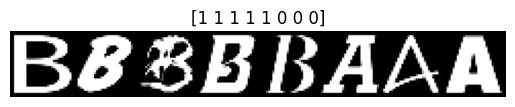

In [46]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images.permute([0, 3, 1, 2]))

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis("off")
plt.title(labels.numpy());

And now with transformations:

In [47]:
train_dataset_with_transform = DatasetMNIST(transform=torchvision.transforms.ToTensor())

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [48]:
img, lab = train_dataset_with_transform.__getitem__(0)

print("image shape at the first row : {}".format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [49]:
train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = next(train_iter_tr)

print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


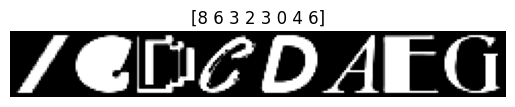

In [50]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis("off")
plt.title(labels.numpy());

### Composing several transformations

If you want to take data augmentation, you have to make List using `torchvision.transforms.Compose`

```
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
```


this function can convert some image by order within `__call__` method.

In [51]:
class ReduceDim(object):
    def __call__(self, item):
        return item[0]

In [53]:
new_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        nn.Flatten(),
        ReduceDim(),
    ]
)

# Putting all together

In [54]:
import time

from IPython.display import clear_output

In [55]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [56]:
dir(device)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'index',
 'type']

In [57]:
device.type, device.index

('cuda', None)

In [58]:
cdev = torch.device('cuda:2')
cdev.type, cdev.index, str(cdev)

('cuda', 2, 'cuda:2')

In [59]:
def subset_ind(dataset, ratio: float):
    return np.random.choice(len(dataset), size=int(ratio * len(dataset)), replace=False)

In [60]:
dataset = DatasetMNIST(
    "./notMNIST_small",
    transform=new_transform,
)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

print(f"\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}")

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


 dataset size: 3370, labels: [0 1 2 3 4 5 6 7 8 9]


In [61]:
dataset[0][0].shape

torch.Size([784])

In [62]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f"  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}")

  training size: 2696
validation size: 674


In [63]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

In [64]:
train_iter = iter(train_loader)

images, labels = next(train_iter)

print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

images shape on batch size = torch.Size([32, 784])
labels shape on batch size = torch.Size([32])


In [65]:
loss_func = nn.CrossEntropyLoss()

In [66]:
default_dtype = torch.float32

In [67]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 10),
    nn.Sigmoid(),
)
model.to(device, default_dtype)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [68]:
preds = torch.rand(3, 10)
preds

tensor([[0.8247, 0.6870, 0.4680, 0.6503, 0.5917, 0.5801, 0.5449, 0.0736, 0.0394,
         0.2369],
        [0.3336, 0.2126, 0.2983, 0.6327, 0.3662, 0.9166, 0.9701, 0.3513, 0.0717,
         0.1920],
        [0.8889, 0.8452, 0.8510, 0.9954, 0.1274, 0.3855, 0.8821, 0.5750, 0.1885,
         0.4279]])

In [69]:
vals, inds = preds.max(-1)

In [70]:
inds

tensor([0, 6, 3])

In [71]:
vals

tensor([0.8247, 0.9701, 0.9954])

In [72]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device):
    """
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    """
    train_loss = []
    val_loss = []
    val_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True)  # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            opt.zero_grad()
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            loss.backward()
            opt.step()

            ep_train_loss.append(loss.item())

        model.train(False)  # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                preds = model(X_batch)
                loss = loss_fn(preds, y_batch)

                # compute predictions
                ep_val_loss.append(loss.item())
                y_pred = preds.max(-1)[1]
                ep_val_accuracy.append(
                    (y_pred == y_batch).to(default_dtype).mean().item()
                )

        # print the results for this epoch:
        print(f"Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s")

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [73]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 1 of 30 took 1.140s
	  training loss: 1.868134
	validation loss: 1.735322
	validation accuracy: 0.838
Epoch 2 of 30 took 0.428s
	  training loss: 1.706665
	validation loss: 1.692763
	validation accuracy: 0.835
Epoch 3 of 30 took 0.434s
	  training loss: 1.670332
	validation loss: 1.668550
	validation accuracy: 0.846
Epoch 4 of 30 took 0.426s
	  training loss: 1.649820
	validation loss: 1.657202
	validation accuracy: 0.839
Epoch 5 of 30 took 0.436s
	  training loss: 1.638583
	validation loss: 1.648459
	validation accuracy: 0.852
Epoch 6 of 30 took 0.490s
	  training loss: 1.629216
	validation loss: 1.644068
	validation accuracy: 0.845
Epoch 7 of 30 took 0.446s
	  training loss: 1.620349
	validation loss: 1.640205
	validation accuracy: 0.852
Epoch 8 of 30 took 0.429s
	  training loss: 1.615485
	validation loss: 1.639102
	validation accuracy: 0.846
Epoch 9 of 30 took 0.445s
	  training loss: 1.608931
	validation loss: 1.635388
	validation accuracy: 0.853
Epoch 10 of 30 took 0.435s
	

In [74]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title("Loss")
    axes[0].plot(train_loss, label="train")
    axes[0].plot(val_loss, label="validation")
    axes[0].legend()
    axes[0].grid()

    axes[1].set_title("Validation accuracy")
    axes[1].plot(val_accuracy)
    axes[1].grid()

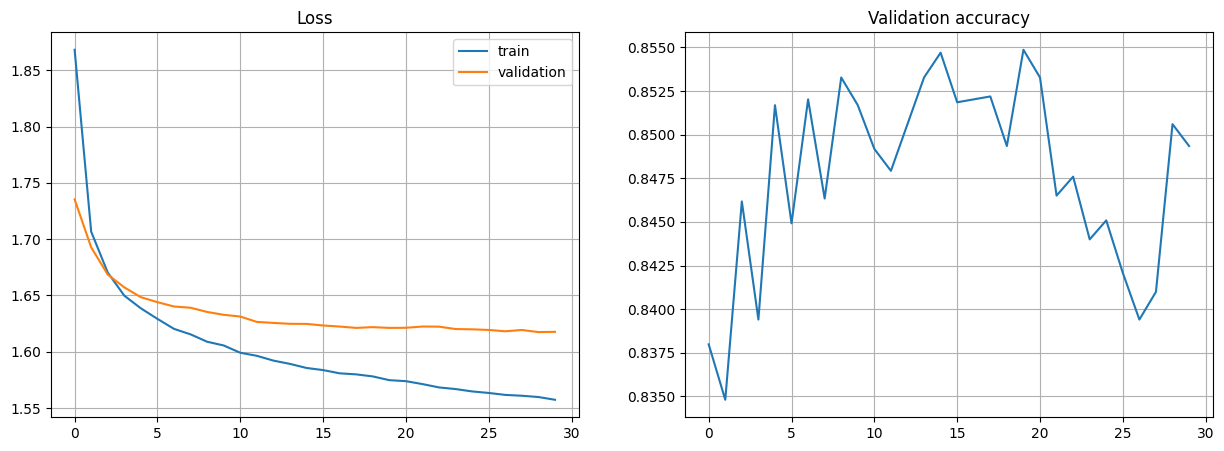

In [75]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Real network

In [76]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.BatchNorm1d(200),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [77]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 1 of 30 took 0.704s
	  training loss: 1.816996
	validation loss: 1.649867
	validation accuracy: 0.861
Epoch 2 of 30 took 0.541s
	  training loss: 1.630651
	validation loss: 1.600777
	validation accuracy: 0.877
Epoch 3 of 30 took 0.535s
	  training loss: 1.583265
	validation loss: 1.585292
	validation accuracy: 0.890
Epoch 4 of 30 took 0.530s
	  training loss: 1.557770
	validation loss: 1.581075
	validation accuracy: 0.872
Epoch 5 of 30 took 0.942s
	  training loss: 1.539725
	validation loss: 1.573410
	validation accuracy: 0.887
Epoch 6 of 30 took 1.240s
	  training loss: 1.527308
	validation loss: 1.567072
	validation accuracy: 0.894
Epoch 7 of 30 took 0.985s
	  training loss: 1.521968
	validation loss: 1.561198
	validation accuracy: 0.894
Epoch 8 of 30 took 1.245s
	  training loss: 1.517202
	validation loss: 1.564631
	validation accuracy: 0.894
Epoch 9 of 30 took 1.376s
	  training loss: 1.508853
	validation loss: 1.560053
	validation accuracy: 0.893
Epoch 10 of 30 took 1.394s
	

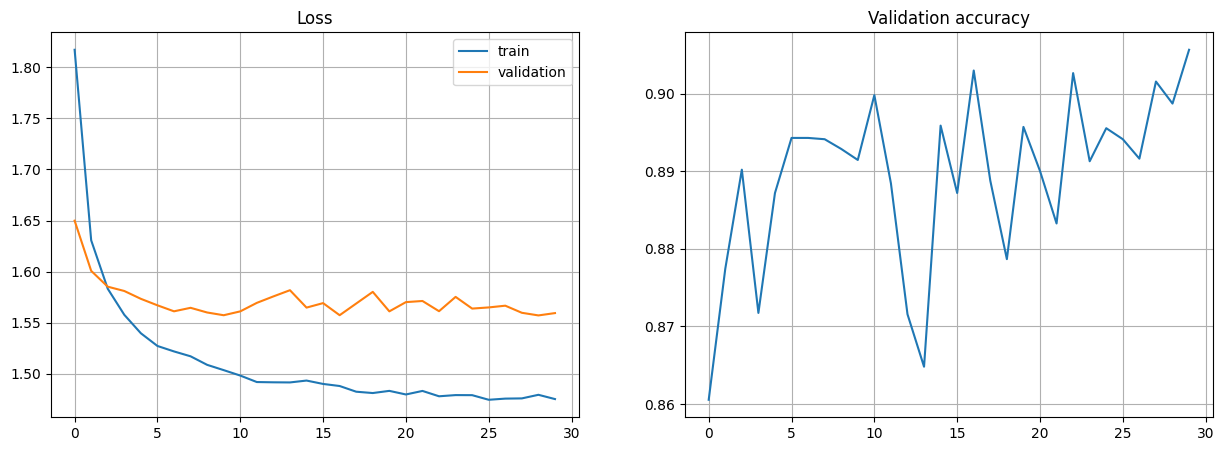

In [79]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [80]:
import torchsummary

In [81]:
torchsummary.summary(model, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]         392,500
              ReLU-2                  [-1, 500]               0
            Linear-3                  [-1, 200]         100,200
       BatchNorm1d-4                  [-1, 200]             400
              ReLU-5                  [-1, 200]               0
           Dropout-6                  [-1, 200]               0
            Linear-7                   [-1, 10]           2,010
           Sigmoid-8                   [-1, 10]               0
Total params: 495,110
Trainable params: 495,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.89
Estimated Total Size (MB): 1.91
----------------------------------------------------------------


## Overfit!!!

In [84]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 600),
    nn.ReLU(),
    nn.Linear(600, 500),
    nn.ReLU(),
    nn.Linear(500, 400),
    nn.ReLU(),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [85]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 1 of 30 took 0.609s
	  training loss: 1.773781
	validation loss: 1.655096
	validation accuracy: 0.664
Epoch 2 of 30 took 0.835s
	  training loss: 1.654012
	validation loss: 1.685643
	validation accuracy: 0.640
Epoch 3 of 30 took 0.840s
	  training loss: 1.640993
	validation loss: 1.659449
	validation accuracy: 0.634
Epoch 4 of 30 took 0.555s
	  training loss: 1.632811
	validation loss: 1.637533
	validation accuracy: 0.683
Epoch 5 of 30 took 0.572s
	  training loss: 1.617648
	validation loss: 1.641037
	validation accuracy: 0.683
Epoch 6 of 30 took 0.585s
	  training loss: 1.606433
	validation loss: 1.621923
	validation accuracy: 0.746
Epoch 7 of 30 took 0.824s
	  training loss: 1.617229
	validation loss: 1.651436
	validation accuracy: 0.624
Epoch 8 of 30 took 0.789s
	  training loss: 1.623479
	validation loss: 1.627302
	validation accuracy: 0.678
Epoch 9 of 30 took 0.742s
	  training loss: 1.626840
	validation loss: 1.642805
	validation accuracy: 0.743
Epoch 10 of 30 took 0.571s
	

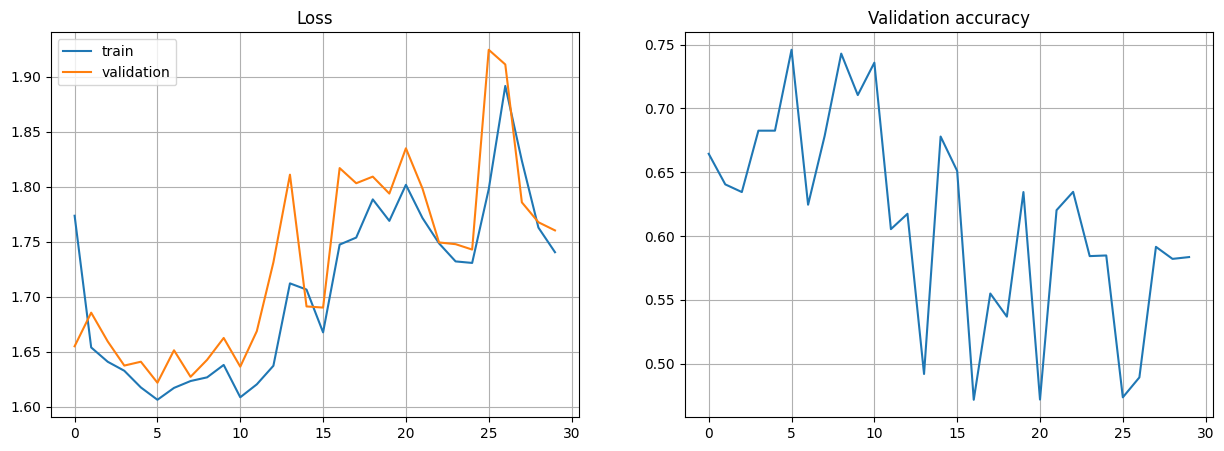

In [86]:
plot_train_process(train_loss, val_loss, val_accuracy)

### 3. Save the model (model checkpointing)

Now we have trained a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [87]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print("model saved to %s" % checkpoint_path)


def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state["state_dict"])
    optimizer.load_state_dict(state["optimizer"])
    print("model loaded from %s" % checkpoint_path)

In [92]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#### Define a training loop with model checkpointing

In [93]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        ep,
                        batch_idx * len(data),
                        len(train_loader.dataset),
                        100.0 * batch_idx / len(train_loader),
                        loss.item(),
                    )
                )
            # different from before: saving model checkpoints
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint("mnist-%i.pth" % iteration, model, optimizer)
            iteration += 1

    # save the final model
    save_checkpoint("mnist-%i.pth" % iteration, model, optimizer)

In [94]:
train_save(5, save_interval=500, log_interval=100)

Train Epoch: 0 [0/2696 (0%)]	Loss: -0.781250
Train Epoch: 1 [480/2696 (18%)]	Loss: -0.718750
Train Epoch: 2 [960/2696 (35%)]	Loss: -0.718750
Train Epoch: 3 [1440/2696 (53%)]	Loss: -0.656250
Train Epoch: 4 [1920/2696 (71%)]	Loss: -0.781250
model saved to mnist-425.pth


In [95]:
load_checkpoint("mnist-425.pth", model, optimizer)

model loaded from mnist-425.pth


<ipython-input-87-78b7dcd0b419>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(checkpoint_path)


### More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)